In [1]:
import numpy as np
import torch
import torch.nn as nn
import math

In [2]:
class PositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding as in "Attention Is All You Need".
    Adds positional information to token embeddings.
    """
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        # Create matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # shape (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor of shape (seq_len, batch_size, d_model)
        Returns:
            x + positional encoding: same shape as input
        """
        seq_len = x.size(0)
        return x + self.pe[:seq_len]


In [3]:
class SpatialTransformerEncoder(nn.Module):
    """
    Captures spatial correlations between joints within each frame.
    Processes all frames in parallel for efficiency.
    """
    def __init__(
        self,
        d_model: int,
        nhead: int,
        num_layers: int,
        num_joints: int,
        dim_feedforward: int = 2048,
        dropout: float = 0.1
    ):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.pos_encoder = PositionalEncoding(d_model, max_len=num_joints)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        input x: Tensor of shape (batch_size, num_frames, num_joints, d_model)
        ouput y: same size
        """
        b, f, j, d = x.shape
        # Combine batch and frame dims: treat each frame as independent sequence
        x = x.view(b * f, j, d).transpose(0, 1)  # (seq_len=j, batch=b*f, d_model=d)
        x = self.pos_encoder(x)
        y = self.transformer(x)  # (j, b*f, d)
        y = y.transpose(0, 1).view(b, f, j, d)
        return y


In [4]:
class TemporalTransformerEncoder(nn.Module):
    """
    Models temporal dependencies across frames.
    """
    def __init__(
        self,
        d_model: int,
        nhead: int,
        num_layers: int,
        num_frames: int,
        dim_feedforward: int = 2048,
        dropout: float = 0.1
    ):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.pos_encoder = PositionalEncoding(d_model, max_len=num_frames)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        input x: Tensor of shape (batch_size, num_frames, num_joints, d_model)
        ouput y: same size
        """
        # Transformer expects (seq_len, batch_size, d_model)
        x = x.transpose(0, 1)  # (num_frames, batch, d_model)
        x = self.pos_encoder(x)
        y = self.transformer(x)
        y = y.transpose(0, 1)  # (batch, num_frames, d_model)
        return y

In [5]:
class HierarchicalTransformer(nn.Module):
    """
    Hierarchical Transformer combining spatial and temporal encoders for exercise recognition.
    Input: X of shape (batch_size, num_frames, num_joints, 3)
    Output: logits over exercise classes
    """
    def __init__(
        self,
        num_joints: int,
        num_frames: int,
        d_model: int,
        nhead: int,
        num_spatial_layers: int,
        num_temporal_layers: int,
        num_classes: int,
        dim_feedforward: int = 2048,
        dropout: float = 0.1
    ):
        super().__init__()
        # Embed 3D coordinates into d_model dims
        self.embedding = nn.Linear(3, d_model)

        # Spatial transformer to capture joint correlations per frame
        self.spatial_encoder = SpatialTransformerEncoder(
            d_model=d_model,
            nhead=nhead,
            num_layers=num_spatial_layers,
            num_joints=num_joints,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )

        # Temporal transformer to capture motion across frames
        self.temporal_encoder = TemporalTransformerEncoder(
            d_model=d_model,
            nhead=nhead,
            num_layers=num_temporal_layers,
            num_frames=num_frames,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )

        # Classification head
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        input x: Tensor of shape (batch_size, num_frames, num_joints, 3)
        output logits: Tensor of shape (batch_size, num_classes)
        """
        # Embed coordinates
        x = self.embedding(x)  # (batch, F, J, d_model)

        # Spatial encoding
        x = self.spatial_encoder(x)  # (batch, F, J, d_model)

        # Aggregate joints per frame (mean pooling)
        x = x.mean(dim=2)  # (batch, F, d_model)

        # Temporal encoding
        x = self.temporal_encoder(x)  # (batch, F, d_model)

        # Global pooling across frames
        x = x.mean(dim=1)  # (batch, d_model)

        # Classification
        logits = self.classifier(x)  # (batch, num_classes)
        return logits

In [6]:
# Load data
data = np.load('data/keypoints/deadlifts_squats_shoulder_press_2025-06-01.npz')
X = data['X'][:, :, :, :3] 
y = data['y']
print(X.shape, y.shape)

(1962, 331, 33, 3) (1962,)


## Training the model

In [7]:
# Training
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [8]:
data = np.load('data/keypoints/deadlifts_squats_shoulder_press_2025-06-01.npz')
X = data['X'][:, :, :, :3]  # drop visibility
y = data['y']

# Convert to PyTorch tensors
X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).long()


X_temp, X_test, y_temp, y_test = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=42)

val_ratio = 0.1 / 0.9  # ≈ 0.1111 of remaining
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, random_state=42)

# Create dataloaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [9]:
torch.unique(y_tensor)

tensor([0, 1, 2])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HierarchicalTransformer(
    num_joints=33,
    num_frames=331,
    d_model=64,
    dim_feedforward=512,
    nhead=4,
    num_spatial_layers=1,
    num_temporal_layers=1,
    num_classes=len(torch.unique(y_tensor))
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [11]:
num_epochs = 30
train_loss_history = []
val_losss_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)
    
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    val_losss_history.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/30 | Train Loss: 1.0866, Acc: 0.4088 | Val Loss: 1.0816, Acc: 0.3909
Epoch 2/30 | Train Loss: 1.0651, Acc: 0.4158 | Val Loss: 1.0652, Acc: 0.3452
Epoch 3/30 | Train Loss: 1.0048, Acc: 0.4828 | Val Loss: 0.9879, Acc: 0.5635
Epoch 4/30 | Train Loss: 0.8734, Acc: 0.6703 | Val Loss: 0.8127, Acc: 0.6497
Epoch 5/30 | Train Loss: 0.7552, Acc: 0.7526 | Val Loss: 0.7210, Acc: 0.7310
Epoch 6/30 | Train Loss: 0.6922, Acc: 0.7768 | Val Loss: 0.7016, Acc: 0.7208
Epoch 7/30 | Train Loss: 0.6409, Acc: 0.7997 | Val Loss: 0.6618, Acc: 0.7107
Epoch 8/30 | Train Loss: 0.5963, Acc: 0.8125 | Val Loss: 0.5745, Acc: 0.8274
Epoch 9/30 | Train Loss: 0.5414, Acc: 0.8450 | Val Loss: 0.5460, Acc: 0.8122
Epoch 10/30 | Train Loss: 0.5099, Acc: 0.8661 | Val Loss: 0.5309, Acc: 0.8426
Epoch 11/30 | Train Loss: 0.4793, Acc: 0.8693 | Val Loss: 0.4996, Acc: 0.8020
Epoch 12/30 | Train Loss: 0.4481, Acc: 0.8846 | Val Loss: 0.4641, Acc: 0.8477
Epoch 13/30 | Train Loss: 0.4215, Acc: 0.8992 | Val Loss: 0.4283, Acc: 0.

In [15]:
# save
torch.save(model.state_dict(), 'models/hierarchical transformer/hierarchical_transformer_weights_2025-06-03_small_1.pth')

In [13]:
from sklearn.metrics import classification_report

# Switch to eval mode
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=['squats', 'deadlifts', "shoulder_press"])  # replace with your actual class names
print(report)

                precision    recall  f1-score   support

        squats       0.92      0.97      0.95        63
     deadlifts       1.00      1.00      1.00        50
shoulder_press       0.98      0.94      0.96        84

      accuracy                           0.96       197
     macro avg       0.97      0.97      0.97       197
  weighted avg       0.97      0.96      0.96       197



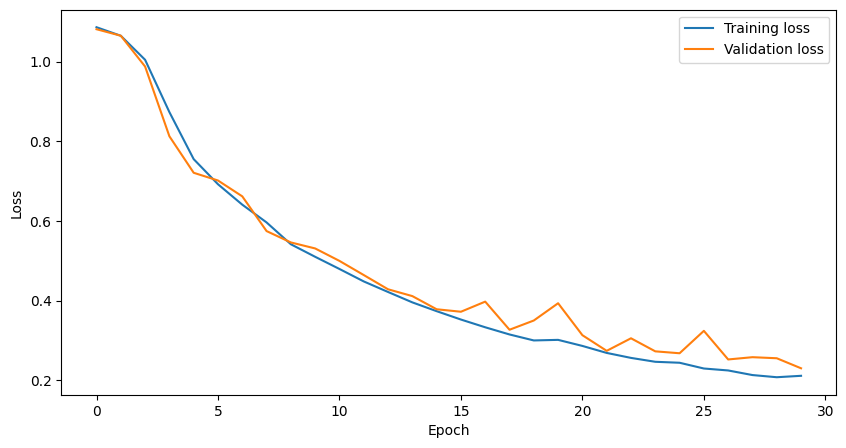

In [14]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_losss_history, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()